# Worksheet 13

Name:  Jiahang Li
UID: U00295086

### Topics

- Support Vector Machines

## Support Vector Machines

a) Follow along in class to implement the perceptron algorithm and create an animation of the algorithm.

In [9]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

TEMPFILE = "temp.png"
CENTERS = [[0, 1], [1, 0]]

# Dataset
X, labels = datasets.make_blobs(n_samples=10, centers=CENTERS, cluster_std=0.2, random_state=0)
Y = np.array(list(map(lambda x : -1 if x == 0 else 1, labels.tolist())))

# Initializing w and b
w = np.array([1, 1])
b = 0.1

# Perceptron Parameters
epochs = 100
alpha = .05
expanding_rate = .99
retracting_rate = 1.1

def snap(x, w, b, error):
    """
        Plot the street induced by w and b.
        Circle the point x in red if it was
        misclassified or in yellow if it was
        classified correctly.
    """
    slope = -w[0] / w[1]
    intercept = -b / w[1]
    left_margin_slope = slope
    left_margin_intercept = intercept - 1 / np.linalg.norm(w)

    right_margin_slope = slope
    right_margin_intercept = intercept + 1 / np.linalg.norm(w)

    
    xplot = np.linspace(-3, 3)
    cs = np.array([x for x in 'gb'])

    svm = slope * xplot + intercept
    left_svm = left_margin_slope * xplot + left_margin_intercept
    right_svm = right_margin_slope * xplot + right_margin_intercept


    fig, ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],color=cs[labels].tolist(), s=50, alpha=0.8)
    if error:
        ax.add_patch(plt.Circle((x[0], x[1]), .2, color='r',fill=False))
    else:
        ax.add_patch(plt.Circle((x[0], x[1]), .2, color='y',fill=False))
    ax.plot(xplot, left_svm, 'g--', lw=2)
    ax.plot(xplot, svm, 'r-', lw=2)
    ax.plot(xplot, right_svm, 'b--', lw=2)
    ax.set_xlim(min(X[:, 0]) - 1, max(X[:,0]) + 1)
    ax.set_ylim(min(X[:, 1]) - 1, max(X[:,1]) + 1)
    fig.savefig(TEMPFILE)
    plt.close()

    return im.fromarray(np.asarray(im.open(TEMPFILE)))


images = []
for _ in range(epochs):
    # pick a point from X at random
    i = np.random.randint(len(X))
    x, y = X[i], Y[i]
    error = False
    output = np.dot(w, x) + b
    if output * y <= 0:
        w = w + alpha * y * x
        b = b + alpha * y
        error = True

                    
    images.append(snap(x, w, b, error))

images[0].save(
    'svm.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=100
)

b) Consider the following dataset:

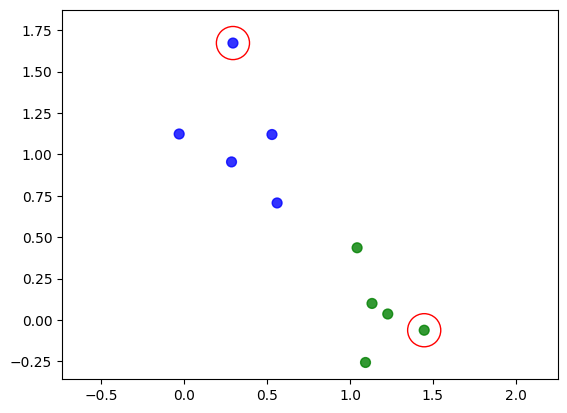

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

centers = [[0, 1], [1, 0]]
X, _ = datasets.make_blobs(n_samples=10, centers=centers, cluster_std=0.3, random_state=0)
Y = np.array([1 if x[0] - x[1] >= 0 else 0 for x in X])

cs = np.array([x for x in 'bg'])
_, ax = plt.subplots()
ax.scatter(X[:,0],X[:,1],color=cs[Y].tolist(), s=50, alpha=0.8)
ax.set_aspect('equal', adjustable='datalim')
ax.add_patch(plt.Circle((X[0][0], X[0][1]), .1, color='r',fill=False))
ax.add_patch(plt.Circle((X[1][0], X[1][1]), .1, color='r',fill=False))
plt.show()

if we fit an SVM to the above dataset, moved the points circled in red, and re-fit the SVM, describe how the fit would change depending on how the points are moved.

c) If we were to fit an SVM to the above dataset, which points do you think would affect the decision boundary the most? Circle them in red.

In [ ]:
If the moved points remain non-support vectors (i.e., they are not the closest points to the decision boundary in their respective classes), the decision boundary will not change, as the SVM only considers support vectors when finding the optimal hyperplane.

If one of the moved points becomes a support vector for its class (i.e., it is now the closest point to the decision boundary in its class), the decision boundary may shift in order to maximize the margin considering the new support vector. This change might be subtle or significant depending on the new position of the point relative to the other points.

If the moved points cross the decision boundary and enter the opposite class's region, the SVM will need to find a new decision boundary that can still separate the two classes. This can lead to a significant change in the decision boundary and possibly a reduction in the margin between the classes.

If the moved points cause the dataset to become linearly inseparable, a linear SVM will not be able to find a perfect decision boundary. In this case, using a kernel trick or allowing some degree of misclassification with a soft-margin SVM may be necessary to find an approximate decision boundary







d) As we saw in class, the form
$$w^T x + b = 0$$
while simple, does not expose the inner product `<x_i, x_j>` which we know `w` depends on, having done the math. This is critical to applying the "kernel trick" which allows for learning non-linear decision boundaries. Let's modify the above algorithm to use the form
$$\sum_i \alpha_i <x_i, x> + b = 0$$

In [12]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

TEMPFILE = "temp.png"
CENTERS = [[0, 1], [1, 0]]

epochs = 100
learning_rate = .05
expanding_rate = .99
retracting_rate = 1.1

X, labels = datasets.make_blobs(n_samples=10, centers=CENTERS, cluster_std=0.2, random_state=0)
Y = np.array(list(map(lambda x : -1 if x == 0 else 1, labels.tolist())))

alpha_i = np.zeros((len(X),))
b = 0

def snap(x, alpha_i, b, error):
    # create a mesh to plot in
    h = .01  # step size in the mesh
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    meshData = np.c_[xx.ravel(), yy.ravel()]
    cs = np.array([x for x in 'gb'])
    fig, ax = plt.subplots()
    ax.scatter(X[:,0],X[:,1],color=cs[labels].tolist(), s=50, alpha=0.8)

    if error:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='r',fill=False))
    else:
        ax.add_patch(plt.Circle((x[0], x[1]), .12, color='y',fill=False))
   
    Z = predict_many(alpha_i, b, meshData)
    Z = np.array([0 if z <=0 else 1 for z in Z]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=.5, cmap=plt.cm.Paired)
    fig.savefig(TEMPFILE)
    plt.close()
    return im.fromarray(np.asarray(im.open(TEMPFILE)))

def predict_many(alpha_i, b, Z):
    res = []
    for i in range(len(Z)):
        res.append(predict(alpha_i, b, Z[i]))
    return np.array(res)

def predict(alpha_i, b, x):
    result = b
    for i in range(len(X)):
        result += alpha_i[i] * np.dot(X[i], x)
    return result

images = []
for _ in range(epochs):
    # pick a point from X at random
    i = np.random.randint(0, len(X))
    error = False
    x, y = X[i], Y[i]
    
    # calculate prediction and error
    pred = predict(alpha_i, b, x)
    err = y * pred - 1
    
    # check if error is within the tolerance
    if np.abs(err) < 0.01:
        continue
        
    # update alpha_i and b
    alpha_i[i] -= y * learning_rate
    b -= err * learning_rate
    
    # check if alpha_i[i] is within bounds
    if alpha_i[i] < 0:
        alpha_i[i] = 0

        
    images.append(snap(x, alpha_i, b, error))

images[0].save(
    'svm_dual.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=100
)

Write a configurable kernel function to apply in lieu of the dot product. Try it out on a dataset that is not linearly separable.

In [ ]:
def polynomial(x_i, x_j, c, n):
    return (np.dot(x_i, x_j) + c) ** n

e) Assume we fit an SVM using a polynomial Kernel function and it seems to overfit the data. How would you adjust the tuning parameter `n` of the kernel function?

The tuning parameter of a polynomial kernel function is the degree of the polynomial, denoted by n.

If the SVM model is overfitting the data with a polynomial kernel function, one way to adjust the tuning parameter is to decrease the degree of the polynomial. This can be done by setting n to a lower value, such as 2 or 3, instead of using a higher value like 4 or 5.

A lower degree polynomial will produce a less complex decision boundary, which is less likely to overfit the training data. However, it is important to keep in mind that decreasing n too much may result in underfitting, where the model is too simple and cannot capture the complexity of the data. Therefore, the choice of the optimal value of n depends on the specific dataset and should be determined through cross-validation or other model selection techniques.

f) Assume we fit an SVM using a RBF Kernel function and it seems to underfit the data. How would you adjust the tuning parameter `sigma` of the kernel function?

If an SVM model with an RBF kernel function is underfitting the data, one way to adjust the tuning parameter sigma is to decrease its value.

The sigma parameter controls the width of the Gaussian distribution used to calculate the similarity between data points. A larger value of sigma results in a smoother decision boundary and can make the model more flexible. On the other hand, a smaller value of sigma results in a more localized decision boundary and can make the model less flexible.

By decreasing the value of sigma, we can make the model more sensitive to small variations in the data and fit the training data better. However, it is important to keep in mind that decreasing sigma too much may result in overfitting, where the model is too complex and can fit noise in the data. Therefore, the optimal value of sigma should be determined through cross-validation or other model selection techniques.

In practice, one approach is to try a range of values for sigma and evaluate the performance of the SVM model on a validation set. The optimal value of sigma can then be chosen based on the performance metric, such as accuracy or F1 score, that is most important for the specific problem.

g) Tune the parameter of a specific Kernel function, to fit an SVM (using your code above) to the following dataset:

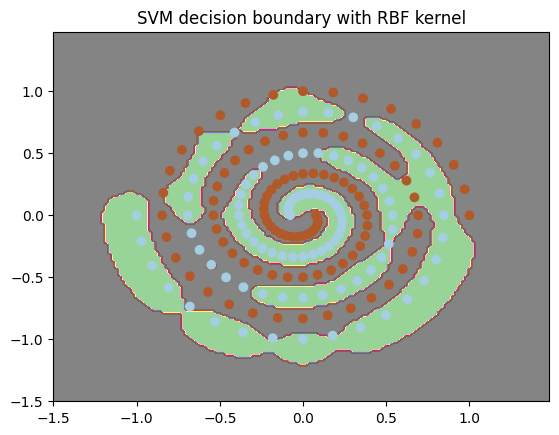

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# Load the dataset
data = np.loadtxt("spiral.data")
x, y = data[:, :2], data[:, 2]

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

# Define a range of values for the sigma parameter
sigma_range = [0.1, 0.5, 1, 2, 5, 10]

# Train an SVM model with RBF kernel for each value of sigma and evaluate its performance
best_acc = 0
best_sigma = None

for sigma in sigma_range:
    # Train the SVM model with RBF kernel and the current value of sigma
    model = SVC(kernel='rbf', gamma=1/(2*sigma**2))
    model.fit(x_train, y_train)

    # Evaluate the model's performance on the validation set
    y_pred = model.predict(x_val)
    acc = accuracy_score(y_val, y_pred)

    # Update the best sigma parameter if the current model has a higher accuracy
    if acc > best_acc:
        best_acc = acc
        best_sigma = sigma

# Train the final SVM model using the best sigma parameter found above
final_model = SVC(kernel='rbf', gamma=1/(2*best_sigma**2))
final_model.fit(x_train, y_train)

# Plot the decision boundary and the data points
h = 0.02  # step size in the mesh
x_min, x_max = x[:, 0].min() - 0.5, x[:, 0].max() + 0.5
y_min, y_max = x[:, 1].min() - 0.5, x[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = final_model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Accent, alpha=0.8)
plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired)
plt.title('SVM decision boundary with RBF kernel')
plt.show()
